# In-depth analysis: finding relationship between the variables and booking prices

## Part 1: Pre-processing

Now, using all the features possible, we will try to inference relations between them to used for the prediction of booking scores.

In [1]:
import gzip
import json
import csv
import pandas as pd
import numpy as np
from scipy import stats
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error 

In [4]:
from xgboost import XGBRegressor

In [5]:
listing = pd.read_csv('../Data/raw/listings.csv.gz', 
                      compression='gzip',
                      error_bad_lines=False, 
                      low_memory=False)

In [6]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

Seaborn package offers the function `pairplot` that allows to create scatterplots of all the variables used as input. If you enter the name of your dataset, you get the visual relation between all the variables and you can start your analysis quickly. As we saw before, this dataset contains 106 columns in different formats. A lot of them neither categorical or numerical. Thus, we select carefully the columns that could it makes sense for the next analysis. How? Using as reference the previos analysis.

In this section we are using df_dataset that select only a couple of columns:

In [7]:
list_columns = ['id',
                'host_id',
                'host_since', 
                'host_response_time', 
                'host_response_rate', 
                'host_is_superhost',
                'neighbourhood_cleansed', 
                'room_type',
                'property_type', 
                'accommodates', 
                'bathrooms', 
                'bedrooms', 
                'beds', 
                'bed_type', 
                'amenities', 
                'price', 
                'extra_people', 
                'minimum_nights',
                'maximum_nights',
                'has_availability',
                'availability_30',
                'availability_60',
                'availability_90',
                'availability_365',
                'number_of_reviews',
                'number_of_reviews_ltm',
                'review_scores_rating',
                'review_scores_accuracy',
                'review_scores_cleanliness',
                'review_scores_checkin',
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value',
                'calculated_host_listings_count',
                'calculated_host_listings_count_entire_homes',
                'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms',
                'reviews_per_month']

In [8]:
df = listing.loc[:, list_columns].reindex()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20025 entries, 0 to 20024
Data columns (total 38 columns):
id                                              20025 non-null int64
host_id                                         20025 non-null int64
host_since                                      19867 non-null object
host_response_time                              10676 non-null object
host_response_rate                              10676 non-null object
host_is_superhost                               19867 non-null object
neighbourhood_cleansed                          20025 non-null object
room_type                                       20025 non-null object
property_type                                   20025 non-null object
accommodates                                    20025 non-null int64
bathrooms                                       20019 non-null float64
bedrooms                                        20012 non-null float64
beds                                            1999

Transforming non-numerical `host_response_rate` to numerical:

In [10]:
def str_rate2int(rate):
    if type(rate) is str:
        return float(rate.replace("%", ""))
    else:
        return rate 

In [11]:
df['host_response_rate_float'] = df.host_response_rate.apply(str_rate2int)

Transforming `price` and `extra_people` from strings to float and `superhost` to binary:

In [12]:
def str2boolean(row):
    if row == 't':
        return 1
    elif row == 'f':
        return 0
    else:
        return np.nan

In [13]:
def price2float(string_price):
    return float(string_price.split('.')[0].replace('$', '').replace(',', ''))

In [14]:
df['superhost'] = df.host_is_superhost.apply(str2boolean)

In [15]:
df['price_float'] = df.price.apply(price2float)

In [16]:
df['extra_people_float'] = df.extra_people.apply(price2float)

Deleting the columns `host_response_rate`, `host_is_superhost`, `price` and `extra_people`:

In [17]:
df.drop(columns=['host_response_rate', 'host_is_superhost', 'price', 'extra_people'], inplace=True)

In [18]:
df.head()

,id,host_id,host_since,host_response_time,neighbourhood_cleansed,room_type,property_type,accommodates,bathrooms,bedrooms,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_response_rate_float,superhost,price_float,extra_people_float
0,2818,3159,2008-09-24,within an hour,Oostelijk Havengebied - Indische Buurt,Private room,Apartment,2,1.5,1.0,...,10.0,1,0,1,0,2.13,100.0,1.0,59.0,20.0
1,20168,59484,2009-12-02,within an hour,Centrum-Oost,Private room,Townhouse,2,1.0,1.0,...,9.0,2,0,2,0,2.57,100.0,0.0,80.0,0.0
2,25428,56142,2009-11-20,within an hour,Centrum-West,Entire home/apt,Apartment,3,1.0,1.0,...,10.0,2,2,0,0,0.13,100.0,0.0,125.0,10.0
3,27886,97647,2010-03-23,within an hour,Centrum-West,Private room,Houseboat,2,1.0,1.0,...,10.0,1,0,1,0,2.14,100.0,1.0,155.0,0.0
4,28871,124245,2010-05-13,within an hour,Centrum-West,Private room,Apartment,2,1.0,1.0,...,10.0,3,0,3,0,2.81,100.0,1.0,75.0,0.0


#### Label Encoding

Encode target labels with value between 0 and n_classes-1. Label encoding is applying to different columns. To avoid redundate code, the function `label_encoding` is built:

In [19]:
def label_encoding(df, target_column, replace_column=False):
    """
    This method receive a dataframe and a string as the name of the column encoded. 
    It returns a column into the dataframe. The new column could replace the original 
    turning replace_column to True.
    """
    lb_make = LabelEncoder()
    encoded_name = lb_make.fit_transform(df[target_column])
    if replace_column:
        df.drop(columns=[target_column], inplace=True)
        
    return encoded_name

In [20]:
df.dropna(subset=['host_response_time'], inplace=True)

In [21]:
df['host_response_time_encode'] = label_encoding(df, 'host_response_time', replace_column=False)

In [22]:
print(df.loc[:, ['host_response_time','host_response_time_encode']].drop_duplicates())

    host_response_time  host_response_time_encode
0       within an hour                          3
9         within a day                          1
10  within a few hours                          2
61  a few days or more                          0


In [23]:
df['neighbourhood_cleansed_encode'] = label_encoding(df, 'neighbourhood_cleansed', replace_column=False)

In [24]:
print(df.loc[:, ['neighbourhood_cleansed','neighbourhood_cleansed_encode']].drop_duplicates())

                     neighbourhood_cleansed  neighbourhood_cleansed_encode
0    Oostelijk Havengebied - Indische Buurt                             14
1                              Centrum-Oost                              4
2                              Centrum-West                              5
10                                     Zuid                             21
12                   De Baarsjes - Oud-West                              7
15                            Bos en Lommer                              2
16                               Westerpark                             20
20                  De Pijp - Rivierenbuurt                              8
30                                 Oud-Oost                             17
37                               Noord-West                             13
50                              Slotervaart                             18
137                               Oud-Noord                             16
152                      

In [25]:
df['room_type_encode'] = label_encoding(df, 'room_type', replace_column=False)

In [26]:
print(df.loc[:, ['room_type','room_type_encode']].drop_duplicates())

           room_type  room_type_encode
0       Private room                 2
2    Entire home/apt                 0
36        Hotel room                 1
418      Shared room                 3


In [27]:
df['property_type_encode'] = label_encoding(df, 'property_type', replace_column=False)

In [28]:
print(df.loc[:, ['property_type','property_type_encode']].drop_duplicates())

                property_type  property_type_encode
0                   Apartment                     1
1                   Townhouse                    29
3                   Houseboat                    21
14                Guest suite                    16
17          Bed and breakfast                     3
37                      House                    20
44                 Guesthouse                    17
48                       Boat                     4
65                Condominium                    12
79                       Loft                    24
137                     Villa                    30
159        Serviced apartment                    26
287                 Farm stay                    15
521                    Chalet                    11
599                  Bungalow                     6
814                Tiny house                    28
939                    Island                    22
1060                    Other                    25
1320        

In [29]:
df['bed_type_encode'] = label_encoding(df, 'bed_type', replace_column = False)

In [30]:
print(df.loc[:, ['bed_type','bed_type_encode']].drop_duplicates())

          bed_type  bed_type_encode
0         Real Bed                4
23           Futon                2
122  Pull-out Sofa                3
241          Couch                1
944         Airbed                0


In the notebook `analysis_neighborhoods`, we got the main amenities on properties. Using them, the following categories have been created:

1. **Safety**: "Smoke detector", "Carbon monoxide detector", "Fire extinguisher", "First aid kit"
2. **Entertainment/work**: Wifi, TV, Cable TV", "Laptop friendly workspace"
3. **Personal care**: Essentials, Shampoo, "Hair dryer" 
4. **Check-in**: In 2 subcategories
    - Host-check-in: Heading, "Host greets you"
    - Self-check-in: "24-hour check-in", "Self check-in"
5. **Kitchen**: Refrigerator, Microwave, "Coffee maker", Dishwasher, "Dishes and silverware", Oven, Kitchen, "Cooking basics" 
6. **Comfort**: Washer, Stove, Dryer, Iron, Hangers, "Hot water", "Bed linens", Air conditioning, ""Extra pillows and blankets", "Indoor fireplace", Breakfast, Bathtub,  "High chair"
7. **Family/kid**: "Family/kid friendly", "Garden or backyard", "Children’s books and toys", "Pets allowed", Crib
8. **Safety entrance**: "Private entrance", "Buzzer/wireless intercom", "Safety card", "Lock on bedroom door", "Well-lit path to entrance"
9. **Parking**: In 3 subcategories
    - "Paid parking off premises"
    - "Free parking on premises"
    - "Paid parking on premises"

In [31]:
safety = ['Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'First aid kit']
entertainment_work = ['Wifi', 'TV', 'Cable TV', 'Laptop friendly workspace']
personal_care = ['Essentials', 'Shampoo', 'Hair dryer']
host_check_in = ['Heading', 'Host greets you']
self_check_in = ['24-hour check-in', 'Self check-in']
kitchen = ['Refrigerator', 'Microwave', 'Coffee maker', 
           'Dishwasher', 'Dishes and silverware', 'Oven', 
           'Kitchen', 'Cooking basics']
comfort = ['Washer', 'Stove', 'Dryer', 'Iron', 'Hangers', 
           'Hot water', "Bed linens", 'Air conditioning', 
           'Extra pillows and blankets', 'Indoor fireplace', 
           'Breakfast', 'Bathtub', 'High chair']
family_kid = ['Family/kid friendly', 'Garden or backyard', 'Children’s books and toys', 'Pets allowed', 'Crib']
safety_entrance = ['Private entrance', 'Buzzer/wireless intercom', 
                   'Safety card', 'Lock on bedroom door', 
                   'Well-lit path to entrance']
paid_parking_off = ['Paid parking off premises']
paid_parking_on = ['Paid parking on premises']
free_parking_on = ['Free parking on premises']

In [32]:
safety_col = []
entertainment_work_col = []
personal_care_col = []
host_check_in_col = []
self_check_in_col = []
kitchen_col = []
comfort_col = []
family_kid_col = []
safety_entrance_col = []
paid_parking_off_col = []
paid_parking_on_col = []
free_parking_on_col = []

In [33]:
def amenities(df, column):
    for j in range(df.shape[0]):
        s = df[column][j].replace('{', '').replace('}', '').replace('"', '').split(',')
        safe = 0
        en = 0
        care = 0
        host = 0
        self = 0
        kitch = 0
        com = 0
        fam = 0
        entrance = 0
        paid_off = 0
        paid_on = 0
        free_on = 0
        for i in s:
            if i in safety:
                safe += 1
            if i in entertainment_work:
                en += 1
            if i in personal_care:
                care += 1
            if i in host_check_in:
                host += 1
            if i in self_check_in:
                self = 1
            if i in kitchen:
                kitch += 1
            if i in comfort:
                com += 1
            if i in family_kid:
                fam += 1
            if i in safety_entrance:
                entrance += 1
            if i in paid_parking_off:
                paid_off += 1
            if i in paid_parking_on:
                paid_on += 1
            if i in free_parking_on:
                free_on += 1
        
        safety_col.append(safe)
        entertainment_work_col.append(en)
        personal_care_col.append(care)
        host_check_in_col.append(host)
        self_check_in_col.append(self)
        kitchen_col.append(kitch)
        comfort_col.append(com)
        family_kid_col.append(fam)
        safety_entrance_col.append(entrance)
        paid_parking_off_col.append(paid_off)
        paid_parking_on_col.append(paid_on)
        free_parking_on_col.append(free_on)
        
    df['safety'] = safety_col
    df['entertainment_work'] = entertainment_work_col
    df['personal_care'] = personal_care_col
    df['host_check_in'] = host_check_in_col
    df['self_check_in'] =  self_check_in_col
    df['kitchen'] = kitchen_col
    df['comfort'] = comfort_col
    df['family_kid'] = family_kid_col
    df['safety_entrance'] = safety_entrance_col
    df['paid_parking_off'] = paid_parking_off_col
    df['paid_parking_on'] = paid_parking_on_col
    df['free_parking_on'] = free_parking_on_col
 
    return df

In [34]:
df.reset_index(inplace=True)

In [35]:
df1 = amenities(df, 'amenities')

In [36]:
df1.columns

Index(['index', 'id', 'host_id', 'host_since', 'host_response_time',
       'neighbourhood_cleansed', 'room_type', 'property_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_response_rate_float', 'superhost', 'price_float',
       'extra_people_float', 'host_response_time_encode',
       'neighbourhood_cleansed_encod

In [37]:
df1.drop(columns=['index', 'host_since'], inplace=True)

## Part 2: Exploratory Data Analysis for Linear Relationships between Features and Outputs

In [38]:
df1.describe()

,id,host_id,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,...,personal_care,host_check_in,self_check_in,kitchen,comfort,family_kid,safety_entrance,paid_parking_off,paid_parking_on,free_parking_on
count,1.067600e+04,1.067600e+04,10676.000000,10673.000000,10667.000000,10654.000000,10676.000000,10676.000000,10676.000000,10676.000000,...,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000
mean,2.141195e+07,6.647708e+07,2.924785,1.213904,1.446330,1.828609,3.104908,590.006557,7.488010,16.801986,...,2.435837,0.307606,0.157643,3.825028,4.655114,0.676283,0.912046,0.296928,0.096103,0.094230
std,1.254118e+07,8.279864e+07,1.427354,0.418560,0.920729,1.604902,11.719886,550.369130,8.894171,19.461128,...,0.759456,0.461524,0.364423,2.999003,2.299702,0.929619,0.861697,0.456926,0.294747,0.292162
min,2.818000e+03,3.159000e+03,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.071052e+07,8.623682e+06,2.000000,1.000000,1.000000,1.000000,2.000000,21.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.138957e+07,2.628509e+07,2.000000,1.000000,1.000000,1.000000,2.000000,999.000000,4.000000,8.000000,...,3.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.303579e+07,9.181281e+07,4.000000,1.500000,2.000000,2.000000,3.000000,1125.000000,13.000000,32.000000,...,3.000000,1.000000,0.000000,7.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,4.065521e+07,3.130924e+08,18.000000,8.000000,12.000000,32.000000,1001.000000,11250.000000,30.000000,60.000000,...,3.000000,1.000000,1.000000,8.000000,13.000000,5.000000,5.000000,1.000000,1.000000,1.000000


The following function `pearson_r` compute the Person correlation coefficient between two variables. In this way, we can measure the relationship between the variables between them and with the outputs.

In [39]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]

In this section, we analyze price and rating according to the rest of variables. Let's visualize some scatterplots to analyse the correlation of the different variables wit respect to the outputs. 

**Does it exist a relationship between the review scores rating (how guests qualify the experience) and the price of the accomodaties?**

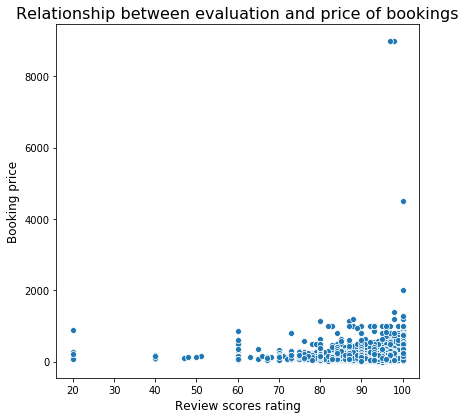

In [40]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.scatterplot(y="price_float", x="review_scores_rating", data=df1)
_ = plt.xlabel("Review scores rating", size=12)
_ = plt.ylabel("Booking price", size=12)
_ = plt.title("Relationship between evaluation and price of bookings", size=16)

Deleting prices above 2000€:

In [41]:
df_prices = df1[df1.price_float < 2000]

<Figure size 468x468 with 0 Axes>

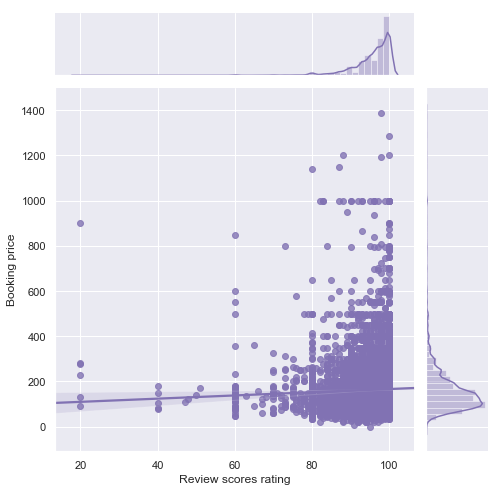

In [42]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.set(style="darkgrid")
_ = sns.jointplot(y="price_float", x="review_scores_rating", data=df_prices,
                  kind="reg", truncate=False,
                  color="m", height=7)
_ = plt.xlabel("Review scores rating", size=12)
_ = plt.ylabel("Booking price", size=12)

There is a slight positive relationship between both variables and it makes sense that the highest accomodation prices imply a best quality of service. Perhaps, excelent evaluations are found in the most expensive and cheapest alternatives. Let's compute the Pearson correlation between ratings and score, avoiding missing values:

In [43]:
# Avoiding nan values using dropna()
df2 = df1.dropna(subset=['review_scores_rating', 'price_float'])
print ('Pearson coefficient between Score Rating and Price = %.3f' %(pearson_r(x=df2.review_scores_rating, y=df2.price_float)))

Pearson coefficient between Score Rating and Price = 0.031


### Let's start analyzing how the different variables impact separately the booking prices:

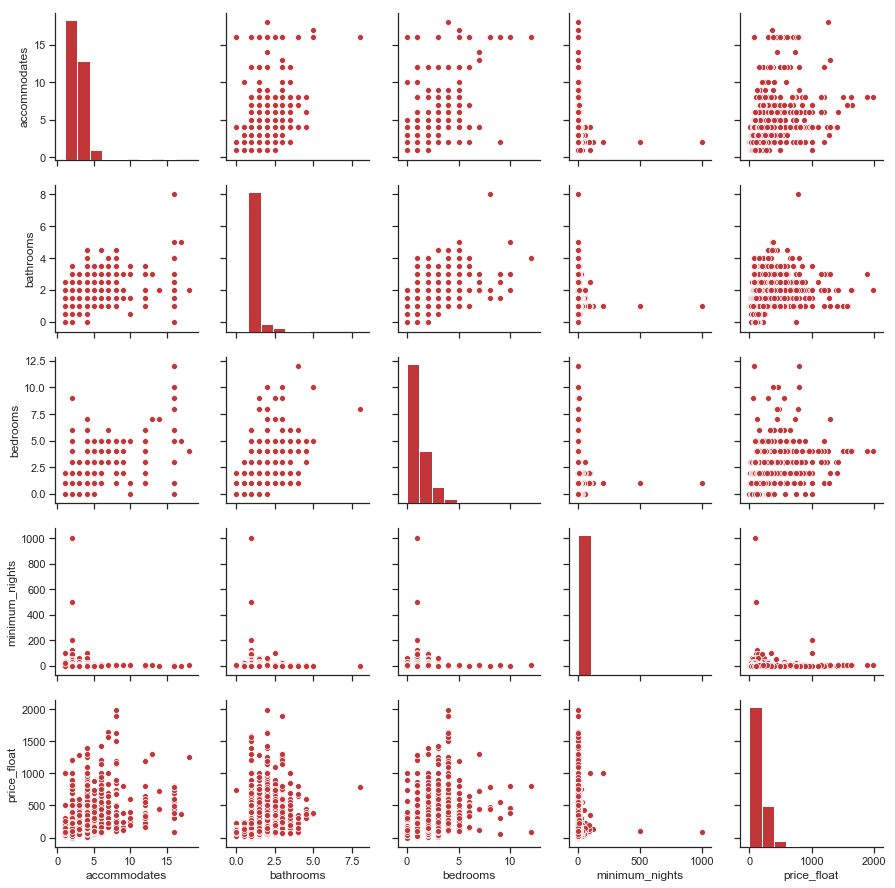

In [44]:
_ = sns.set(style="ticks", palette='RdBu', color_codes=True)
_ = sns.pairplot(df_prices, vars=['accommodates', 'bathrooms', 'bedrooms', 'minimum_nights', 'price_float'])

It seems that the number of accommodates, bathrooms and bedrooms have positive relationships with the price, with Pearson correlations of 0.472, 0.318 and 0.426 respectively. Perhaps, they are correlated between them too. For instances, the Pearson correlation between `Accommodates` and `Bedrooms` is 0.723. Considering all of them in a linear model could generate a poor performance causing non-zero variance in the residuals and a high multicollinearity coefficient. The selected variables must be independent between them to avoid that.

In [45]:
# Avoiding nan values using dropna()
df_accom = df_prices.dropna(subset=['accommodates', 'price_float'])
print ('Pearson coefficient between Accommodates and Price = %.3f' %(pearson_r(x=df_accom.accommodates, 
                                                                               y=df_accom.price_float)))

df_bath = df_prices.dropna(subset=['bathrooms', 'price_float'])
print ('Pearson coefficient between Bathrooms and Price = %.3f' %(pearson_r(x=df_bath.bathrooms, 
                                                                               y=df_bath.price_float)))

df_bed = df_prices.dropna(subset=['bedrooms', 'price_float'])
print ('Pearson coefficient between Bedrooms and Price = %.3f' %(pearson_r(x=df_bed.bedrooms, 
                                                                               y=df_bed.price_float)))

df_AccomBath = df_prices.dropna(subset=['accommodates', 'bathrooms'])
print ('Pearson coefficient between Accommodates and Bathrooms = %.3f' %(pearson_r(x=df_AccomBath.accommodates, 
                                                                               y=df_AccomBath.bathrooms)))

df_BedBath = df_prices.dropna(subset=['bedrooms', 'bathrooms'])
print ('Pearson coefficient between Bedrooms and Bathrooms = %.3f' %(pearson_r(x=df_BedBath.bedrooms, 
                                                                               y=df_BedBath.bathrooms)))

df_AccomBed = df_prices.dropna(subset=['accommodates', 'bedrooms'])
print ('Pearson coefficient between Accommodates and Bedrooms = %.3f' %(pearson_r(x=df_AccomBed.accommodates, 
                                                                               y=df_AccomBed.bedrooms)))

Pearson coefficient between Accommodates and Price = 0.472
Pearson coefficient between Bathrooms and Price = 0.318
Pearson coefficient between Bedrooms and Price = 0.426
Pearson coefficient between Accommodates and Bathrooms = 0.379
Pearson coefficient between Bedrooms and Bathrooms = 0.460
Pearson coefficient between Accommodates and Bedrooms = 0.723


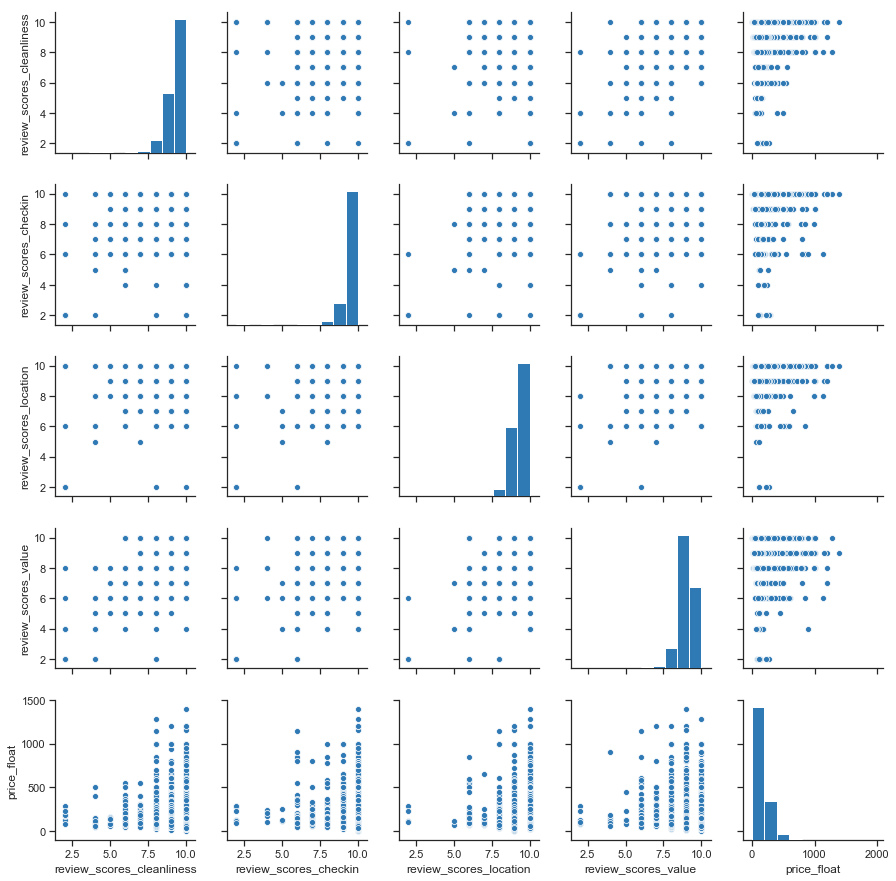

In [46]:
_ = sns.set(style="ticks", palette='RdBu_r')
_ = sns.pairplot(df_prices, vars=['review_scores_cleanliness', 
                                  'review_scores_checkin',
                                  'review_scores_location', 
                                  'review_scores_value',
                                  'price_float'])  

And it's not surprise that the different review scores categories are linked with the price accomodations, as the average review score. Next, we check host `host_response_time_encode`, `host_response_rate_float`, `superhost` and `reviews_per_month` and `extra_people_float`:

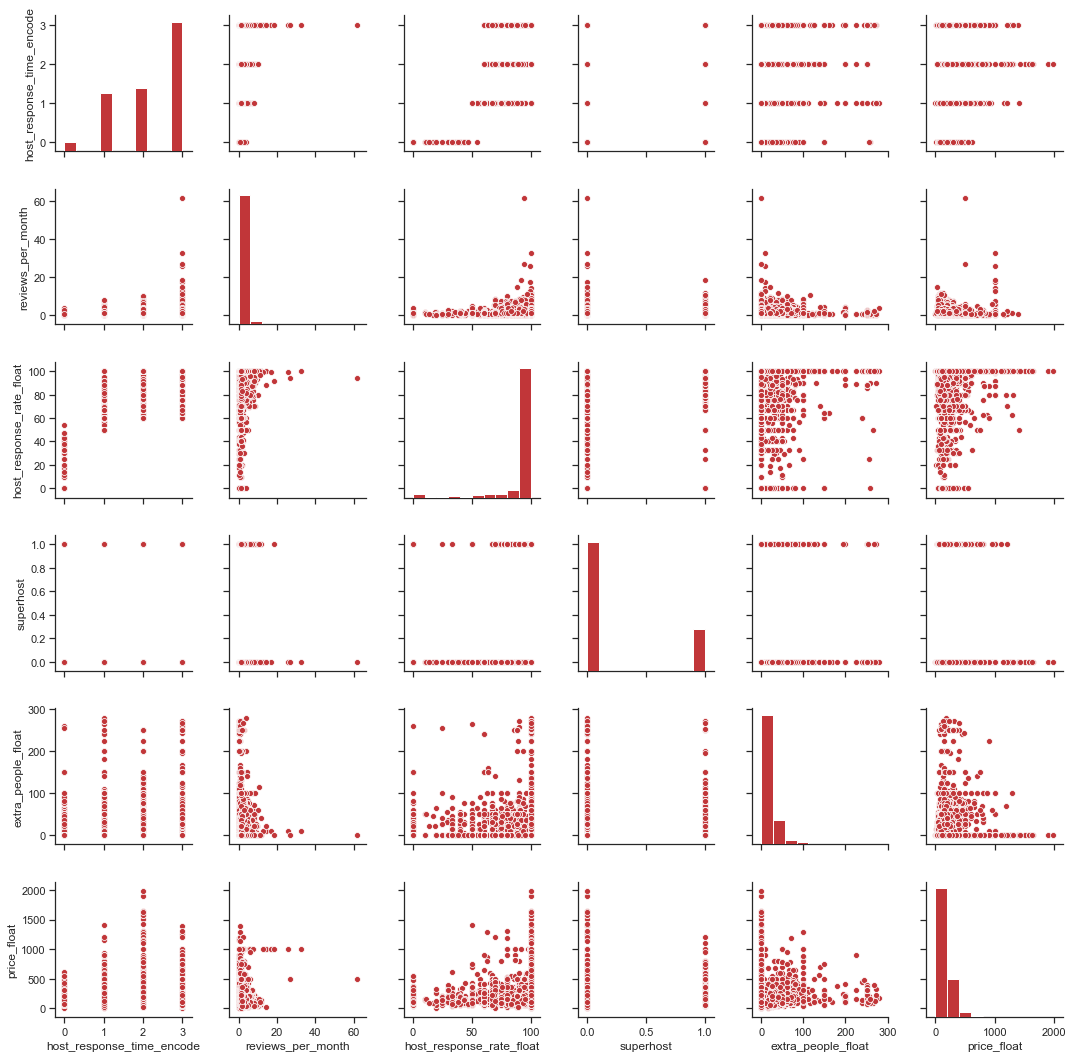

In [47]:
_ = sns.set(style="ticks", palette='RdBu', color_codes=True)
_ = sns.pairplot(df_prices, vars=['host_response_time_encode', 
                                  'reviews_per_month', 
                                  'host_response_rate_float',
                                  'superhost',
                                  'extra_people_float', 
                                  'price_float'])  

Let's check the encode response time:

| Host Time Response | Encode |
| --- | --- |
| within an hour | 3 |
|  within a day | 1 |
|  within a few hours | 2 |
| a few days or more | 0 |

We observe that the accomodations where hosts response more quicky (within a few hours) concentrate the widest range of prices, including the more expensive bookings. Meanwhile, the bookings where hosts take more time in response have the range of lowest prices. It means that it exists a relation between host diligence and price of bookings.

On the other hands, `host_response_rate_float` is directly related to price of services. The impact of extra people is strong in cheapest and regular prices, but not for the more expensive bookings as we can see in the scatterplot that shows the relantionship between the `price_float` and `extra_people_float`. Curiosity, the highest prices are related to no super-hosts and as we can expect, the most expensive accomodations are not necessarily the most popular and they don't receive as much reviews per month as affordable bookings.

In [48]:
# Avoiding nan values using dropna()
df_rev = df_prices.dropna(subset=['reviews_per_month', 'price_float'])
print ('Pearson coefficient between Reviews per Month and Price = %.3f' %(pearson_r(x=df_rev.reviews_per_month, 
                                                                                    y=df_rev.price_float)))

df_HostResp = df_prices.dropna(subset=['host_response_rate_float', 'price_float'])
print ('Pearson coefficient between Host Response Rate and Price = %.3f' %(pearson_r(x=df_HostResp.host_response_rate_float, 
                                                                                     y=df_HostResp.price_float)))

df_ExtraPeople = df_prices.dropna(subset=['extra_people_float', 'price_float'])
print ('Pearson coefficient between Extra People Price and Price = %.3f' %(pearson_r(x=df_ExtraPeople.extra_people_float, 
                                                                                     y=df_ExtraPeople.price_float)))

Pearson coefficient between Reviews per Month and Price = -0.095
Pearson coefficient between Host Response Rate and Price = -0.002
Pearson coefficient between Extra People Price and Price = 0.058


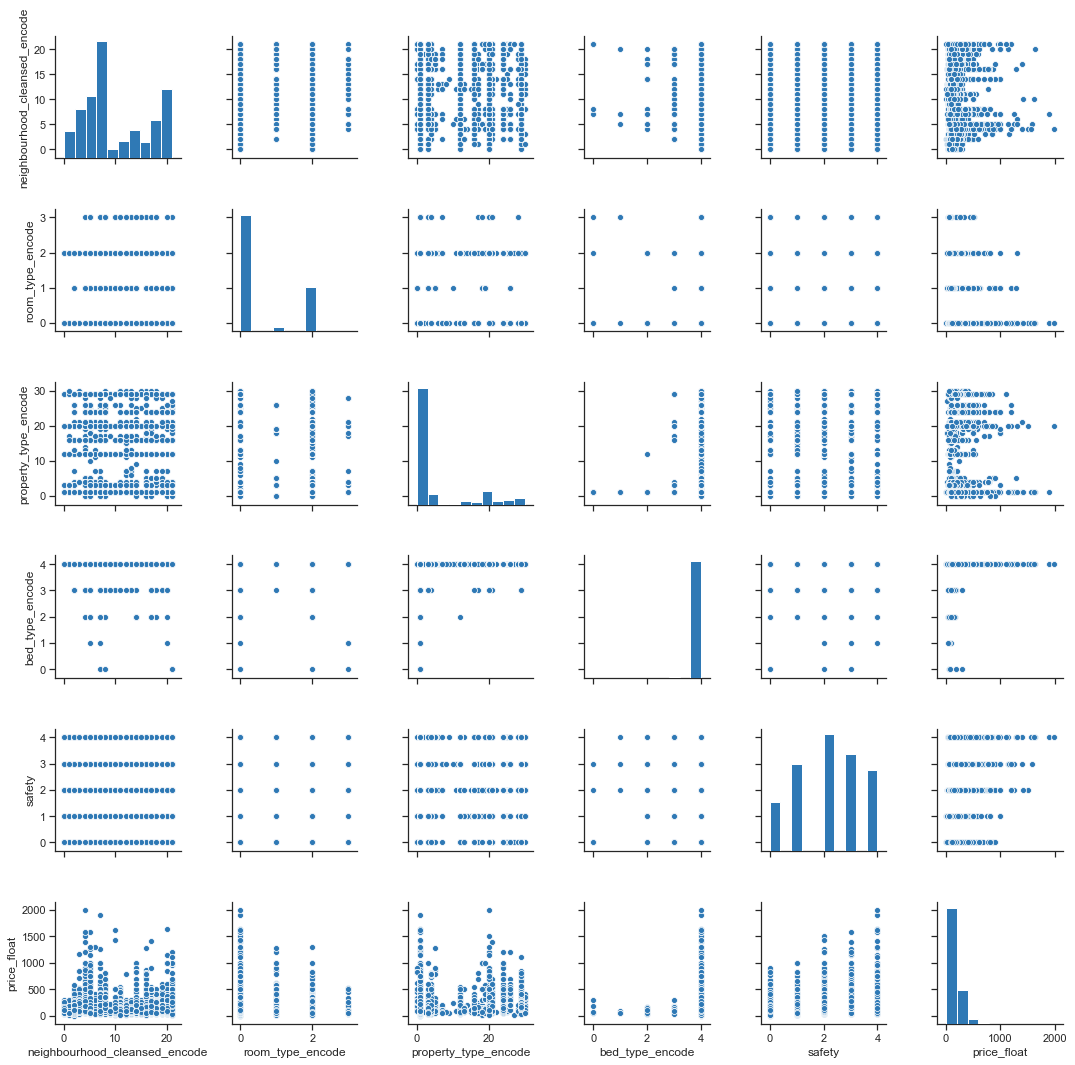

In [49]:
_ = sns.set(style="ticks", palette='RdBu_r')
_ = sns.pairplot(df_prices, vars=['neighbourhood_cleansed_encode', 
                                               'room_type_encode', 
                                               'property_type_encode',
                                               'bed_type_encode',
                                               'safety', 
                                               'price_float'])  

Let's check the encode room and bed types:

| Room Type | Encode |
| --- | --- |
| Private room | 2 |
| Entire home/apt | 0 |
| Hotel room | 1 |
| Shared room | 3 |

| Bed Type | Encode |
| --- | --- |
| Real Bed| 4 |
| Futon  | 2 |
| Pull-out Sofa | 3 |
| Couch | 1 |
| Airbed | 0 |

The **type of room** represented by `room_type_encode`, impacts directly the price: entire homes or apartments are the most expensive accomodations, followed by hotel and private rooms (both of them with very similar ranges of prices). The more affordable options are shared rooms. The same analysis in **type of bed** results on highest prices in accommodations with *Real Beds*. The other alternatives -futons, pull-out sofa, couches and airbeds- offer more accesible prices in bookings.

**Safety** is one of the categories of amenities that we have defined previously. As we can observe, more safety items (as smoke detectors, carbon monoxide detectors and fire extinguishersI imply a wide range of prices including, subsequently, highest booking prices.

According to the scatterplots, there are correlations between some neighborhoods and property types with the price of the accommodations. 

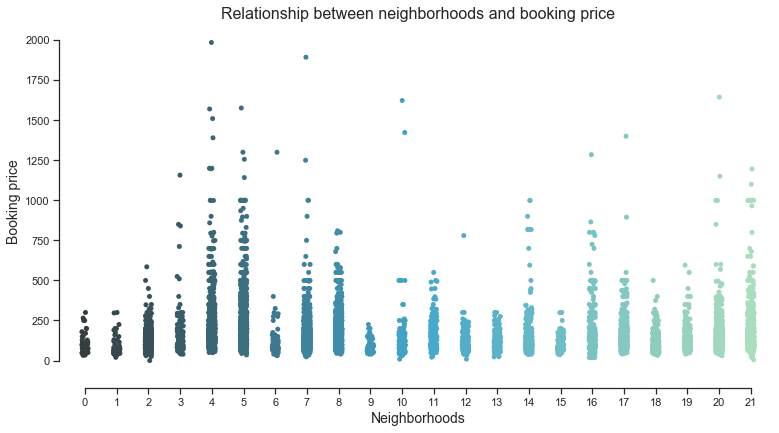

In [50]:
_ = plt.figure(figsize=(12.5, 6.5))
_ = sns.stripplot(x='neighbourhood_cleansed_encode', 
                  y='price_float',
                  data=df_prices,
                  palette='GnBu_d')
_ = plt.xlabel('Neighborhoods', size=14)
_ = plt.ylabel('Booking price', size=14)
_ = plt.title("Relationship between neighborhoods and booking price", size=16)
_ = sns.despine(offset=10, trim=True)

| Neighbourhood | Encode |
| --- | --- |
| Bijlmer-Centrum | 0 |
| Bijlmer-Oost | 1 |
| Bos en Lommer | 2 | 
| Buitenveldert - Zuidas | 3 |
| Centrum-Oost | 4 |
| Centrum-West | 5 |
| De Aker - Nieuw Sloten | 6 |
| De Baarsjes - Oud-West | 7 |
| De Pijp - Rivierenbuurt | 8 |
| Gaasperdam - Driemond | 9 |
| Geuzenveld - Slotermeer | 10 |
| IJburg - Zeeburgereiland | 11 |
| Noord-Oost | 12 |
| Noord-West | 13 |
| Oostelijk Havengebied - Indische Buurt | 14 |
| Osdorp | 15 |
| Oud-Noord | 16 |
| Oud-Oost | 17 |
| Slotervaart | 18 |
| Watergraafsmeer | 19 |
| Westerpark | 20 |    
| Zuid | 21 |

Booking prices above 1000 € can be found in **Buitenveldert - Zuidas**, **Centrum-Oost**, **Centrum-West**, **De Baarsjes - Oud-West**, **Geuzenveld - Slotermeer**, **Oud-Noord**, **Oud-Oost**, **Westerpark** and **Zuid**. 
Other facts that we can check grouping the bookings by neighborhoods:

- Centrum-Oost and Centrum-West have the highest average booking price (above 200 €).
- Bijlmer-Centrum and Gaasperdam - Driemond have the lowest average booking price (below 100 €).

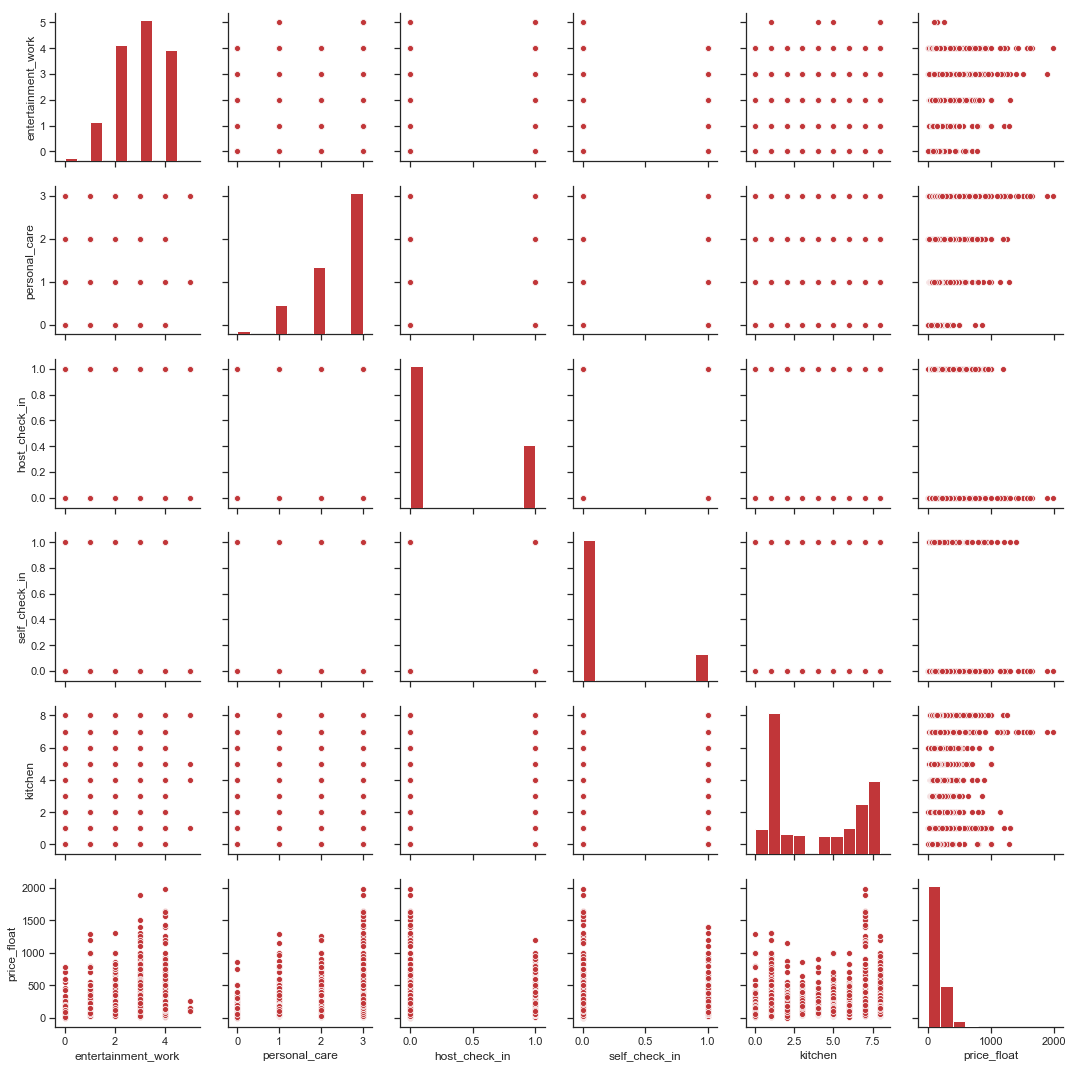

In [51]:
_ = sns.set(style="ticks", palette='RdBu')
_ = sns.pairplot(df_prices, vars=['entertainment_work', 
                                  'personal_care', 
                                  'host_check_in',
                                  'self_check_in',
                                  'kitchen', 
                                  'price_float'])  

Some observations from the below plots:

- Host check and self check don't represent a plus in price of booking.
- It seems that the addition of elements in the kitchen, personal care and entertainment/work stuff (as laptop friendly environments, TV and Wifi) imply an increase in prices.

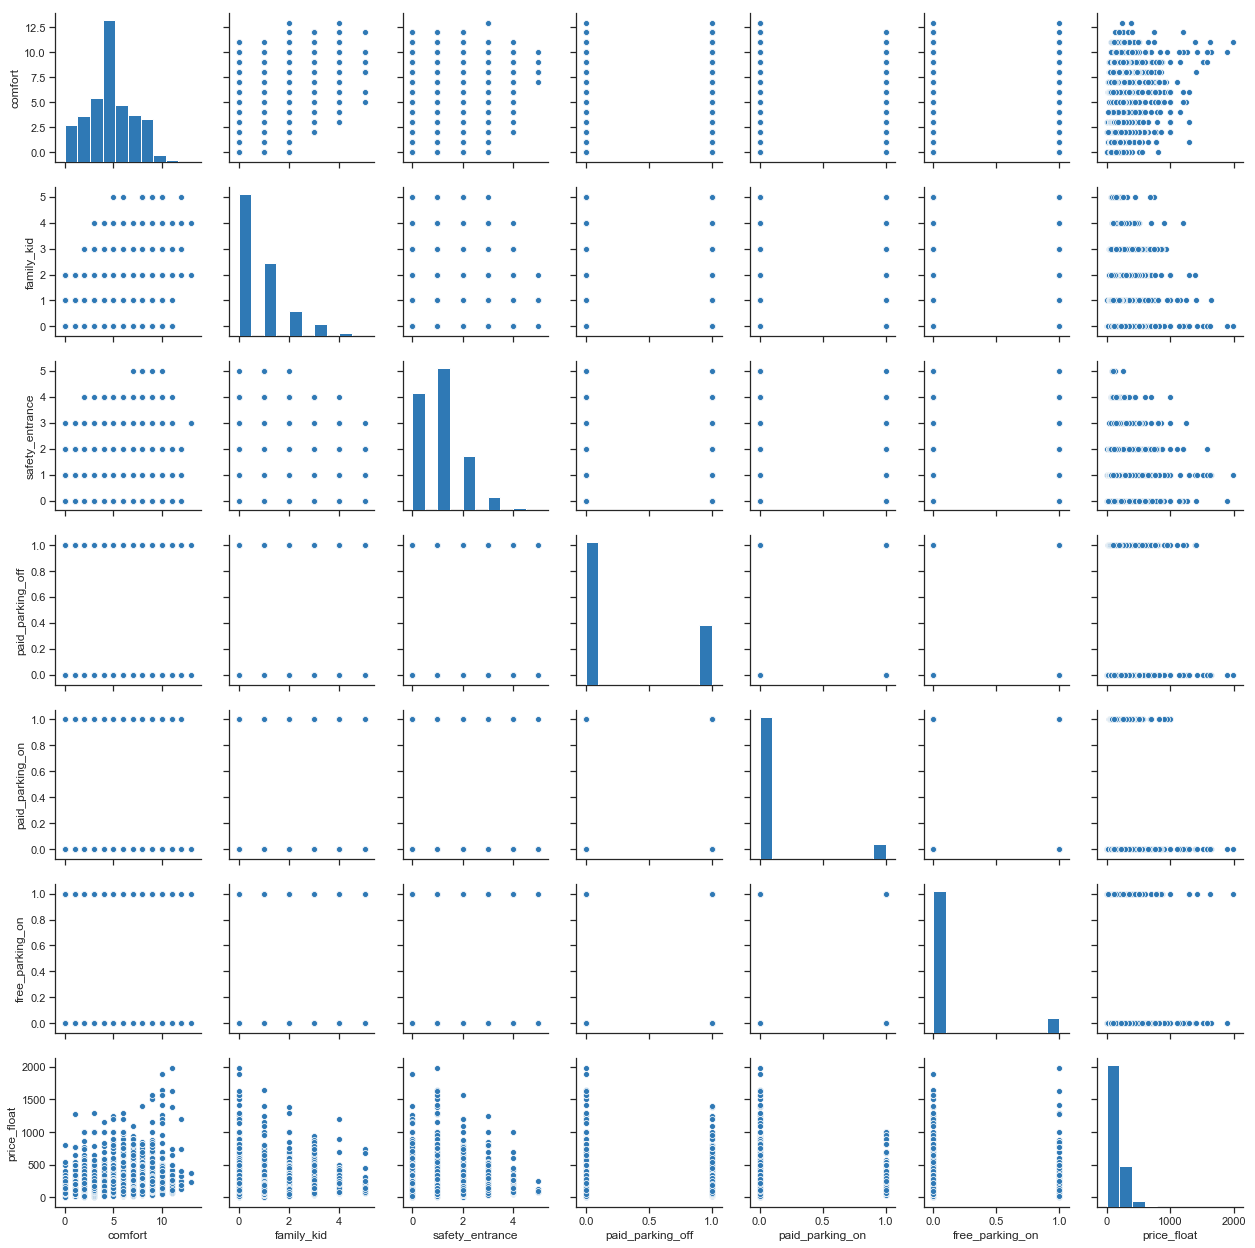

In [52]:
_ = sns.set(style="ticks", palette='RdBu_r')
_ = sns.pairplot(df_prices, vars=['comfort', 
                                  'family_kid', 
                                  'safety_entrance',
                                  'paid_parking_off',
                                  'paid_parking_on', 
                                  'free_parking_on',
                                  'price_float'])  

**Comfort items** (like washers, stoves, irons, hot water, bed lines, air conditioning and hangers) impact directly the booking prices. On the other hand, the addition of more **family/kid** stuff seems affect negatively the ranges of prices. The age group or traveling purposes could explain that. It's reasonable to think that business trips or young people traveling with friends, partners are not traveling with their whole family and they don't require kid, pet and family friendly extra amenities.

What about **parking**?
- Free parking doesn't increase the price of bookings.
- Paid Parking in/out the properties don't seem justify increase on prices.

In [53]:
df_prices.rename(columns={'price_float': 'TARGET PRICE'}, inplace=True)

The following heat map displays the correlation between all the variables. 

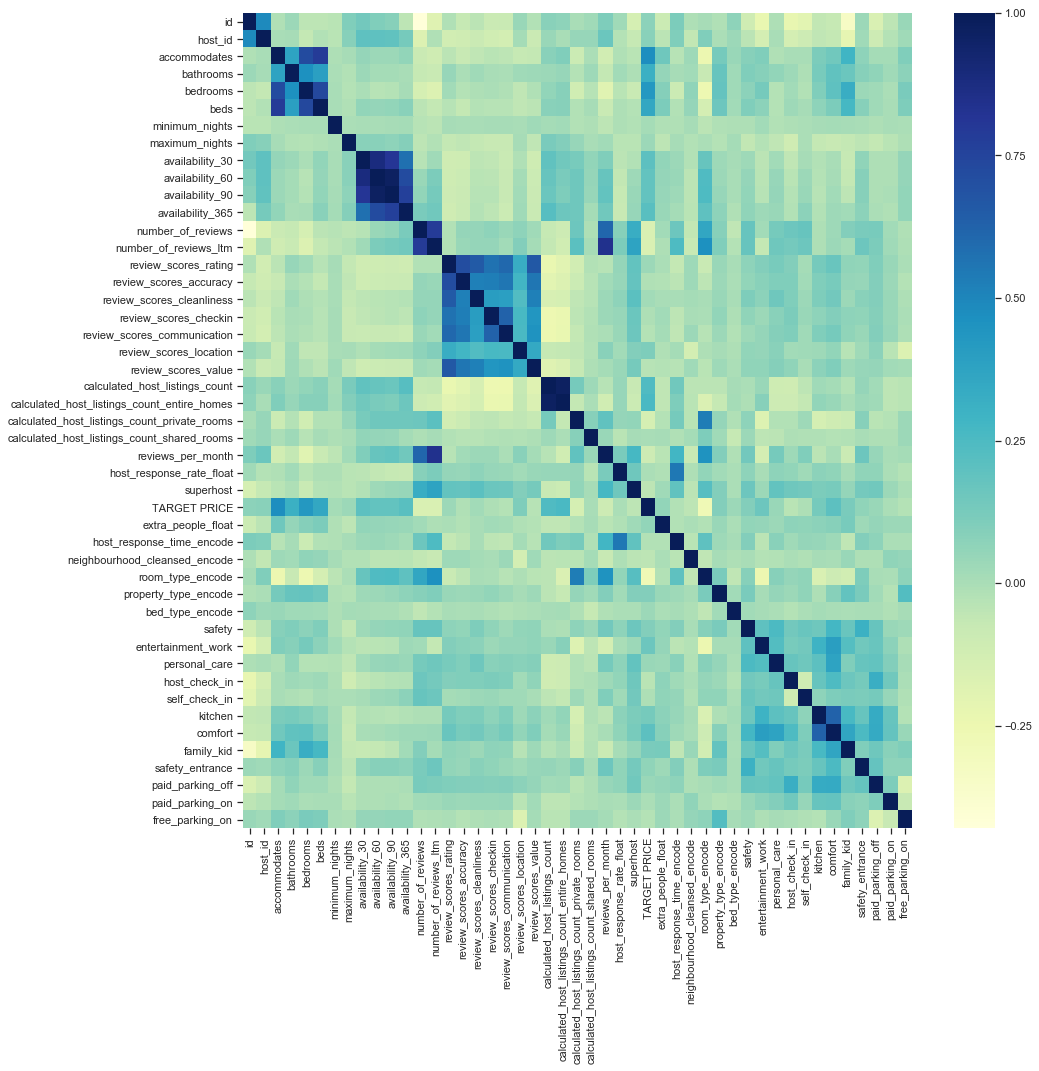

In [54]:
C_mat = df_prices.corr()
fig = plt.figure(figsize = (15,15))

_ = sns.heatmap(C_mat, square = False, cmap="YlGnBu")
_ = plt.show()

<div class="alert alert-block alert-info">
<b>Summary of Findings</b>

- The number of `accommodates`, `bathrooms` and `bedrooms` have positive relationships with the price, with Pearson correlations of 0.472, 0.318 and 0.426 respectively.
- Booking prices above 1000 € can be found in Buitenveldert - Zuidas, Centrum-Oost, Centrum-West, De Baarsjes - Oud-West, Geuzenveld - Slotermeer, Oud-Noord, Oud-Oost, Westerpark and Zuid. Centrum-Oost and Centrum-West have the highest average booking price (above 200 €) and Bijlmer-Centrum and Gaasperdam - Driemond have the lowest average booking price (below 100 €).
- `Host_response_rate_float` is directly related to price of services. The impact of extra people is strong in cheapest and regular prices, but not for the more expensive bookings as we can see in the scatterplot that shows the relantionship between the price and `extra_people_float`. 
- The highest prices are related to no super-hosts and the most expensive accomodations are not necessarily the most popular and they don't receive as much reviews per month as affordable bookings.
- The `availability` in the next 30, 60, 90 and 365 days is correlated to the price.
- The `calculated_host_listings_count_entire_homes` and `calculated_host_listings_count` are related too.
- The type of room represented by `room_type_encode`, impacts directly the price: entire homes or apartments are the most expensive accomodations, followed by hotel and private rooms (both of them with very similar ranges of prices). The more affordable options are shared rooms. 
- Real Beds result in highest prices related to the other alternatives (futons, pull-out sofa, couches and airbeds) in `bed_type_encode`.
- Property types represented by `property_type_encode` indicates that entire houses and apartments are most expensive that rooms and shared spaces.
- Some amenities are slightly correlated to the listing price, `entertainment_work` (TV, Wifi, laptop desktops), `comfort` stuff (like washers, stoves, irons, hot water, bed lines, air conditioning and hangers) and `kitchen` items.
- The number of reviews (total and last month) impacts negatively the prices, as well as the `calculated_host_listings_count_private_rooms`, `reviews_per_month`.

</div>

## Part 3: Predictive Modeling of Listing prices

Filtering only the variables apparently more correlated to listing prices, 

In [55]:
df2 = df_prices.loc[:, ['accommodates', 'bathrooms', 'bedrooms', 
                        'host_response_rate_float', 'extra_people_float',
                        'availability_30', 'availability_60', 'availability_90',
                        'availability_365', 'calculated_host_listings_count_entire_homes',
                        'calculated_host_listings_count', 'room_type_encode', 
                        'property_type_encode', 'bed_type_encode', 'entertainment_work', 
                        'comfort', 'kitchen', 'reviews_per_month',
                        'calculated_host_listings_count_entire_homes', 
                        'calculated_host_listings_count_private_rooms',
                        'TARGET PRICE', 
                       ]]

<div class="alert alert-block alert-info">
<b>One Hot Encoding</b>

Label Encoding was used previously to represent property, room and bed Type as digits and identify them easily in plots but this encoding technique is not the best choice for training machine learning models. Instead, we perform a binarization of the categorical variables before including them as training features.

</div>

In [56]:
def oneHotEncode(df, name_column):
    dummies = pd.get_dummies(df[name_column], prefix=name_column)
    df = pd.concat([df,dummies],axis=1)

    df.drop([name_column], axis = 1 , inplace=True)
    return df

In [57]:
df2 = oneHotEncode(df2, 'room_type_encode')
df2 = oneHotEncode(df2, 'property_type_encode')
df2 = oneHotEncode(df2, 'bed_type_encode')

df2.head()

,accommodates,bathrooms,bedrooms,host_response_rate_float,extra_people_float,availability_30,availability_60,availability_90,availability_365,calculated_host_listings_count_entire_homes,...,property_type_encode_26,property_type_encode_27,property_type_encode_28,property_type_encode_29,property_type_encode_30,bed_type_encode_0,bed_type_encode_1,bed_type_encode_2,bed_type_encode_3,bed_type_encode_4
0,2,1.5,1.0,100.0,20.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,1.0,100.0,0.0,4,21,51,198,0,...,0,0,0,1,0,0,0,0,0,1
2,3,1.0,1.0,100.0,10.0,2,26,26,71,2,...,0,0,0,0,0,0,0,0,0,1
3,2,1.0,1.0,100.0,0.0,16,43,69,251,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1.0,1.0,100.0,0.0,0,2,10,134,0,...,0,0,0,0,0,0,0,0,0,1


Then, variables and output are split in X and y:

In [101]:
X = df2.loc[:,~df2.columns.duplicated()]
X.dropna(inplace=True)

y = X['TARGET PRICE']
X = X.drop(columns=['TARGET PRICE'])

In [105]:
print('Feature vectors size: {}'.format(X.shape) + '\nTargets size: {}'.format(y.shape))

Feature vectors size: (9647, 55)
Targets size: (9647,)


<div class="alert alert-block alert-info">
<b>Data Scaling</b>

Next, we proceed to normalize all the variables in X dataframe before use them as training features. Nornalization consists on rescaling of the data from the original range so that all values are within the range of 0 and 1. The object **MinMaxScaler** of scikit-learn allows us to normalize the data. The default scale for the MinMaxScaler is to rescale variables into the range [0,1]

</div>

In [106]:
scaler = MinMaxScaler()
# fit and transform in one step
normalized = scaler.fit_transform(X)
# inverse transform
inverse = scaler.inverse_transform(normalized)

In [107]:
print(normalized)

[[0.0625     0.1875     0.08333333 ... 0.         0.         1.        ]
 [0.0625     0.125      0.08333333 ... 0.         0.         1.        ]
 [0.125      0.125      0.08333333 ... 0.         0.         1.        ]
 ...
 [0.3125     0.1875     0.16666667 ... 0.         0.         1.        ]
 [0.125      0.125      0.16666667 ... 0.         0.         1.        ]
 [0.0625     0.125      0.08333333 ... 0.         0.         1.        ]]


Finally, we determine that randomly selected, 80% of data belongs to the **training** set and the rest 20% correspond to **test** data:

In [108]:
X_train, X_test, y_train, y_test = train_test_split(normalized, y, train_size=0.8, test_size=0.2, random_state=21)

In [109]:
X_train

array([[0.25      , 0.25      , 0.33333333, ..., 0.        , 0.        ,
        1.        ],
       [0.1875    , 0.125     , 0.16666667, ..., 0.        , 0.        ,
        1.        ],
       [0.0625    , 0.125     , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.0625    , 0.125     , 0.08333333, ..., 0.        , 0.        ,
        1.        ],
       [0.0625    , 0.1875    , 0.08333333, ..., 0.        , 0.        ,
        1.        ],
       [0.0625    , 0.1875    , 0.08333333, ..., 0.        , 0.        ,
        1.        ]])

### 3.1 XGBoost Regression

The following step is tunning the parameters of our model. Some parameters of the ensemble model XGBoost Regression are: 

- `learning_rate`: Choose a high learning rate usually works.
-  Number of trees for this learning rate or `n_estimators`.
- `max_depth` This should be between 3-10.
-  Tune regularization parameters (`reg_lambda`, `reg_alpha`) for xgboost can help reduce model complexity and improve performance. We set them between 1e-5 and 0.75 (alpha) and (lambda).

We define a default model called `xgbRegression` with initial values, but all of them are tuned later.

In [110]:
#for tuning parameters
parameters_tuning = {
   'colsample_bytree':[0.4,0.8],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[1000],
   'reg_alpha':[1e-5, 0.75],
   'reg_lambda':[1e-5, 0.45],
   'gamma':[0, 0.3]
}

xgbRegression = XGBRegressor(learning_rate =0.1, n_estimators=500, max_depth=5,
                         min_child_weight=1, gamma=0, subsample=0.8, objective='reg:squarederror',
                         colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

tuning_model = GridSearchCV(estimator = xgbRegression, param_grid = parameters_tuning, n_jobs=6, iid=False, verbose=10, scoring='neg_mean_squared_error')
tuning_model.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   16.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   17.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   47.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  42 out of  48 | elapsed:  2.1min remaining:   18.2s
[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed:  2.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=6, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=6,
       param_grid={'colsample_bytree': [0.4, 0.8], 'learning_rate': [0.1], 'max_depth': [3], 'n_estimators': [1000], 'reg_alpha': [1e-05, 0.75], 'reg_lambda': [1e-05, 0.45], 'gamma': [0, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

Printing the best parameters and the best score:

In [111]:
print('best params: {}'.format(tuning_model.best_params_))
print('best score: {}'.format(tuning_model.best_score_))

best params: {'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.75, 'reg_lambda': 0.45}
best score: -6401.7174021514575


Finally, applying the best parameters to the final version of the model:

In [112]:
xgbReg = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=3,
                          min_child_weight=1, gamma=0, subsample=0.8, objective='reg:squarederror',
                          colsample_bytree=0.4, nthread=6, scale_pos_weight=1, seed=27, 
                          reg_alpha=0.75, reg_lambd=0.45)

In [113]:
xgbReg.fit(X_train, y_train , verbose=False)
xgb_predictions = xgbReg.predict(X_test)

<div class="alert alert-block alert-info">
<b>Why MAE instead RMSE?</b>

- If the focus is the variance of the error, MAE is better for an interpretation standpoint. RMSE increases with the variance of the frequency distribution of error magnitudes.
- In the real world, when you are trying to compare models and performances, the size of the test sample changes. RMSE has a tendency to be increasingly larger than MAE in sized test samples.

</div>

In [114]:
MAE = mean_absolute_error(y_test , xgb_predictions)
print('XGBoost Regression validation MAE = ', MAE)

XGBoost Regression validation MAE =  48.10817656047604


Displaying the prices and predictions:

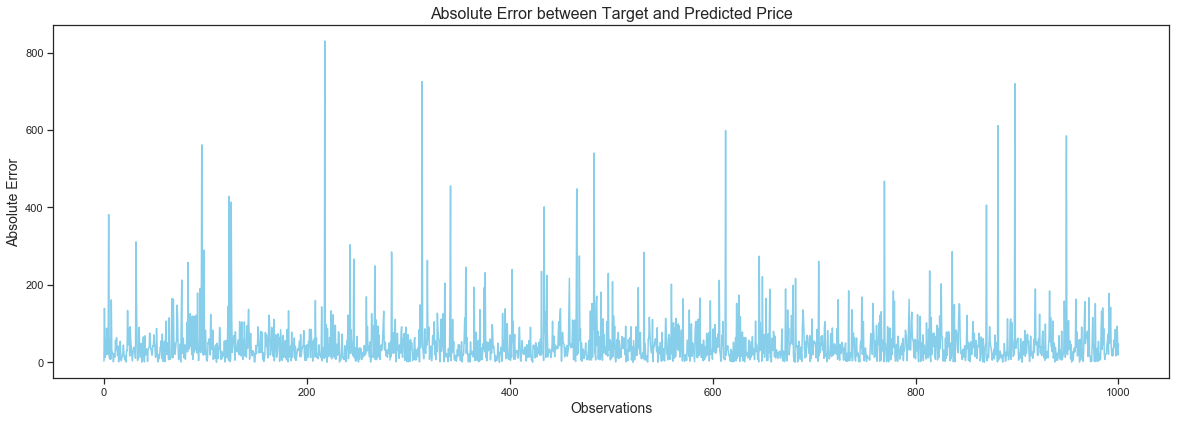

In [115]:
xh = np.linspace(0, 1000, len(y_test))

_ = plt.figure(figsize=(20, 6.5))
_ = sns.lineplot(x=xh, y=np.abs(y_test-xgb_predictions), color='skyblue')
_ = plt.xlabel('Observations', size=14)
_ = plt.ylabel('Absolute Error', size=14)
_ = plt.title('Absolute Error between Target and Predicted Price', size=16)

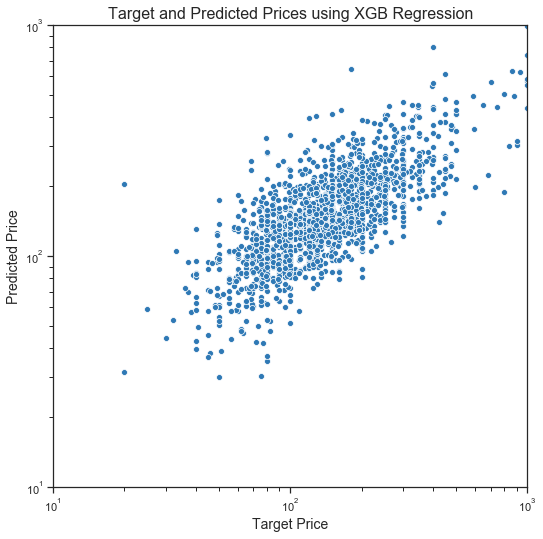

In [119]:
_ = plt.figure(figsize=(8.5, 8.5))
_ = plt.xscale('log')
_ = plt.yscale('log')
_ = sns.scatterplot(x=y_test, y=xgb_predictions)
_ = plt.xlabel('Target Price', size=14)
_ = plt.ylabel('Predicted Price', size=14)
_ = plt.title('Target and Predicted Prices using XGB Regression', size=16)
_ = plt.xlim(10, 1000)
_ = plt.ylim(10, 1000)

Saving training and test sets for training a Deep Learning model in the next section:

In [117]:
header = str(list(X.columns)).replace('[','').replace(']','').replace("'", "")

In [118]:
np.savetxt('../Data/processed/x_train.csv', X_train, header=header, delimiter=",")
np.savetxt('../Data/processed/y_train.csv', y_train, header='target', delimiter=",")
np.savetxt('../Data/processed/x_test.csv', X_test, header=header, delimiter=",")
np.savetxt('../Data/processed/y_test.csv', y_test, header='target', delimiter=",")